# We are going to look at making the GloVE based version of Node2Vec

This is the GloVE as node2vec is to word2vec.

Papers:

 - [GloVE](http://www.aclweb.org/anthology/D14-1162)
 - [node2vec](https://cs.stanford.edu/people/jure/pubs/node2vec-kdd16.pdf)

In [ ]:
using Pkg
pkg"activate .."

In [2]:
#pkg"add LinearAlgebra"

# Loading Data

Les Mis, from Knuth



We will use:

 - the **JSON** package for loading the dat.
 - **LightGraphs** with its **SimpleWeightedGraph**  component for representing it as a graph
 - **MLDataUtils** to convert the node labels between text and node id

In [3]:
using JSON
using LightGraphs, SimpleWeightedGraphs
using MLDataUtils

First we load the raw JSON

In [4]:
const data = JSON.parse(open("jean.json"))

Dict{String,Any} with 2 entries:
  "nodes" => Any[Dict{String,Any}("id"=>"Myriel","group"=>1), Dict{String,Any}(…
  "links" => Any[Dict{String,Any}("source"=>"Napoleon","target"=>"Myriel","valu…

We'll define helper function to change between name and id

In [185]:
const characters = LabelEnc.NativeLabels([character["id"] for character in data["nodes"]])
char_id(name) = convertlabel(LabelEnc.Indices, name, characters)
char_name(ind) = MLDataUtils.ind2label(ind, characters) # hack around https://github.com/JuliaML/MLLabelUtils.jl/issues/18

const char_group = [character["group"] for character in data["nodes"]];

Now we will load it up into a graph.
It is a weighted, undirectional graph

In [6]:
const les_graph = SimpleWeightedGraph(nlabel(characters))
for link in data["links"]
    add_edge!(les_graph,
        char_id(link["source"]),
        char_id(link["target"]),
        link["value"]
    )
end
les_graph

┌ Warning: Note: adding edges to this graph type is not performant.
└ @ SimpleWeightedGraphs /home/wheel/oxinabox/.julia/packages/SimpleWeightedGraphs/UuCCE/src/simpleweightedgraph.jl:96


{77, 254} undirected simple Int64 graph with Float64 weights

We can look at the weighter graph

In [10]:
collect(weights(les_graph))

77×77 Array{Float64,2}:
  0.0  1.0  8.0  10.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  8.0  0.0  0.0   6.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 10.0  0.0  6.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  5.0  0.0  3.0   3.0  0.0  0.0  0.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 

# Now we want to avoid taking random walks

Node2Vec takes random walks, to get sequences of word(nodes), which it feeds to word2vec.

Instread we want to get a matrix that corresponds to the co-occurrencee matrix in GloVE.
Which has elements that are weighted counts of how often words(nodes) occur in the same window.



$A$ is the adjancency matrix.
Nodes directly connected to neighbours

In [12]:
A  = adjacency_matrix(les_graph)

77×77 SparseArrays.SparseMatrixCSC{Int64,Int64} with 508 stored entries:
  [2 ,  1]  =  1
  [3 ,  1]  =  1
  [4 ,  1]  =  1
  [5 ,  1]  =  1
  [6 ,  1]  =  1
  [7 ,  1]  =  1
  [8 ,  1]  =  1
  [9 ,  1]  =  1
  [10,  1]  =  1
  [12,  1]  =  1
  [1 ,  2]  =  1
  [1 ,  3]  =  1
  ⋮
  [49, 76]  =  1
  [69, 76]  =  1
  [70, 76]  =  1
  [71, 76]  =  1
  [72, 76]  =  1
  [49, 77]  =  1
  [59, 77]  =  1
  [63, 77]  =  1
  [64, 77]  =  1
  [65, 77]  =  1
  [66, 77]  =  1
  [67, 77]  =  1

We need to get a co-occurrence matrix $X$,
which has entries given by the count of how often each node occurred in the context of another node.
Where context is determined by window size.

Graph theory tells us for nodes, $i$ and $j$
 - $A_{ij}$ is there a connection between node $i$ and node $j$
 - $(A^2)_{ij}$ number of walks of length 2 from node $i$ to node $j$
 - $(A^n)_{ij}$ number of walks of length n from node $i$ to node $j$
 
 
GLoVE uses decreasing weighting such that words $d$ apart contribute $\frac{1}{d}$ to the coocurance count  (GloVE paper section 4.2).


Thus for window size $N$,

$$
X = \sum_{n=1}^{n=N}   \frac{A^n}{n}
$$


This (I believe) extends intutitively and without change to:
 - using a **weight** matrix instread of an **adjancency** matrix.
 - Or to using a directed graph, via **asymetrical** adjancency matrix
 - Or both.
Normalization may be required.


 

In [13]:
function cooccurance_matrix(A, window_size)
    X = Float32.(A)
    Ap = A
    
    for n in 2 : window_size
        Ap *= A
        X .+= Ap./n
    end
    X
end

cooccurance_matrix (generic function with 1 method)

The downside of this method is that it is fairly expensive.
Matrix multiplication of a matrix with average $k$ nonzero elements
is (slightly better in theory, but roughly) $O(k^3)$.

Thus for window size $N$,
that the calculation of the cooccurance matrix is
$O(nk^3)$

Not also that sparsity doesn't help as much as we would like,
and each successive matrix multiplication is less sparse.

In [16]:
@time X = cooccurance_matrix(collect(A), 5)

  0.998871 seconds (1.47 M allocations: 71.474 MiB, 4.54% gc time)


77×77 Array{Float32,2}:
 127.65    34.8333  115.017   115.017   …   38.4833   206.0      137.85 
  34.8333   4.2      18.0667   18.0667       2.45      14.3        8.15 
 115.017   18.0667   91.95     92.7333      37.0833   197.6      133.65 
 115.017   18.0667   92.7333   91.95        37.0833   197.6      133.65 
  34.8333   4.2      18.0667   18.0667       2.45      14.3        8.15 
  34.8333   4.2      18.0667   18.0667  …    2.45      14.3        8.15 
  34.8333   4.2      18.0667   18.0667       2.45      14.3        8.15 
  34.8333   4.2      18.0667   18.0667       2.45      14.3        8.15 
  34.8333   4.2      18.0667   18.0667       2.45      14.3        8.15 
  34.8333   4.2      18.0667   18.0667       2.45      14.3        8.15 
  62.1167  10.2333   58.9667   58.9667  …   32.1833   169.0      117.35 
 765.967   62.1167  697.483   697.483      380.1     1853.23    1518.18 
  87.05    12.0833   82.5      82.5         39.9333   225.883    139.45 
   ⋮                       

# Now lets solve GLoVE

Fine matrixes C and V such that
$$
loss = f(X)(CV - \log X)^2
$$
is minimized


we use 

 - Optim as a global optimizer

In [17]:
using Optim

Define the problem.
We will be storing $C$ and $V$ in the same matrix as that is how GLoVE likes ot handle memory. We call that combo `CV`.

We also need to define the weighting function $f$ (we use the GLoVE defn here, I don't think it is optimal though.)

And the Loss, which we express as function of X that returns a function of `CV`

In [19]:
function split_CV(CV)
    C = @view(CV[:, 1:end÷2])'
    V = @view(CV[:, end÷2+1:end])
    C,V
end

const xmax = 100
const α = 2/3

f(x) = x < xmax ? (x/xmax)^α : 1.0

loss(X)=function (CV)
    C,V = split_CV(CV)
    sum(f.(X) * (C*V .- log.(X)).^2)
end

loss (generic function with 1 method)

Now to fire off the Optimizer

In [47]:
num_dims = 16
CV = randn(num_dims, 2size(X,1)) # Twice the size as we need to split it off
res = optimize(loss(X), CV, LBFGS(), 
    Optim.Options(show_trace=true,
        #iterations = 200
        time_limit = 5*60 #seconds
        ))

Iter     Function value   Gradient norm 
     0     1.465958e+07     4.359829e+04
     1     9.519550e+06     2.792328e+04
     2     2.845302e+06     1.112419e+05
     3     1.155138e+06     3.157157e+04
     4     2.584911e+05     1.329107e+04
     5     1.831195e+05     9.766707e+03
     6     1.209924e+05     6.440853e+03
     7     8.584785e+04     4.431290e+03
     8     6.949686e+04     4.021958e+03
     9     5.723261e+04     3.164766e+03
    10     4.810486e+04     2.719151e+03
    11     3.720668e+04     3.226355e+03
    12     2.711645e+04     3.128809e+03
    13     2.112864e+04     1.865994e+03
    14     1.731377e+04     2.417813e+03
    15     1.354619e+04     2.010272e+03
    16     1.074690e+04     1.575245e+03
    17     9.303234e+03     1.278200e+03
    18     7.819925e+03     1.116280e+03
    19     6.715845e+03     1.533538e+03
    20     5.746494e+03     1.483222e+03
    21     4.724295e+03     1.090125e+03
    22     4.068409e+03     6.288472e+02
    23     3.727

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.024805772578811735,-0.7720315886734496, ...]
 * Minimizer: [-0.10010273252214376,-0.09650316755236711, ...]
 * Minimum: 1.252843e+03
 * Iterations: 37
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.68e-02 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 7.59e-02 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.83e+02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 111
 * Gradient Calls: 111

In [50]:
C,V = split_CV(res.minimizer)

([-0.100103 -0.0965032 … -1.68361 -0.204844; 0.185617 -0.432191 … -1.27079 -1.06709; … ; -0.170353 -0.593038 … -1.49797 -0.805711; 0.381816 -0.584476 … -1.81649 -0.598615], [0.0955229 -0.707881 … -0.21032 0.466066; 0.262625 -0.198147 … -0.267013 -0.347799; … ; -1.78473 -1.31709 … -1.3145 -1.24411; -0.814341 -0.122892 … -0.99751 -0.480277])

# Investigate results


Just investigating the `C` embedding matrix for now,
though we have the `V` matrix as well.

In Glove they use the sum of the `C` and `V`.

## NearestNeighbors

In [58]:
using NearestNeighbors, Distances

┌ Info: Precompiling NearestNeighbors [b8a86587-4115-5ab1-83bc-aa920d37bbce]
└ @ Base loading.jl:1187


In [59]:
size(C)

(77, 16)

In [99]:
balltree = BallTree(collect(C'), Euclidean(); reorder = false)
function nearestneighbours(id, n=5, balltree=balltree)
    ids, dists = knn(balltree, C'[:,id], n, true)
    [char_name.(ids) dists]
end

function nearestneighbours(name::AbstractString, args...)
    nearestneighbours(char_id(name), args...)
end

nearestneighbours (generic function with 4 methods)

In [102]:
nearestneighbours("Valjean", 10)

10×2 Array{Any,2}:
 "Valjean"            0.0     
 "Thenardier"         0.667668
 "Javert"             0.731243
 "Gavroche"           0.918564
 "Babet"              0.936689
 "Claquesous"         0.988014
 "Mlle.Gillenormand"  1.05546 
 "Marius"             1.06188 
 "Eponine"            1.08583 
 "Gillenormand"       1.09065 

In [109]:
nearestneighbours("Cosette", 25)

25×2 Array{Any,2}:
 "Cosette"            0.0     
 "Babet"              0.807724
 "Toussaint"          0.931347
 "Champmathieu"       0.943286
 "Thenardier"         1.05093 
 "Javert"             1.0541  
 "Simplice"           1.06544 
 "Gillenormand"       1.07766 
 "Woman1"             1.18255 
 "Fauchelevent"       1.20778 
 "Montparnasse"       1.23035 
 "Valjean"            1.25585 
 "Eponine"            1.31704 
 "Labarre"            1.31912 
 "Marius"             1.32544 
 "Gavroche"           1.39051 
 "Mlle.Gillenormand"  1.41576 
 "Marguerite"         1.44631 
 "Chenildieu"         1.45732 
 "Woman2"             1.50369 
 "Bamatabois"         1.52571 
 "Mlle.Baptistine"    1.54608 
 "Judge"              1.585   
 "MotherInnocent"     1.60536 
 "Claquesous"         1.60656 

## TSne

In [137]:
using TSne
using Plots
gr()

Plots.GRBackend()

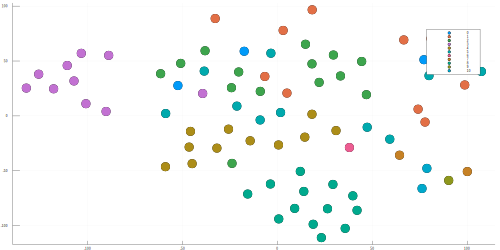

In [156]:
Y = tsne(C, 2, 50,1000, 20.0)
scatter(Y[:,1], Y[:,2],  group=char_group;
    markersize=20, size=(2000,1000))

## Clustering

In [190]:
using Clustering

function show_cluster(res)
    for cluster in unique(assignments(res))
        for id in 1:nlabel(characters)
            if assignments(res)[id]==cluster
                println(char_group[id], "\t", char_name(id))
            end
        end
        println("-------------------------------")
    end
end

show_cluster (generic function with 1 method)

In [191]:
res = affinityprop(pairwise(CosineDist(), C'))
show_cluster(res)

1	Myriel
1	Mlle.Baptistine
1	Mme.Magloire
1	CountessdeLo
1	Cravatte
2	Labarre
2	Valjean
3	Marguerite
2	Mme.deR
2	Isabeau
2	Gervais
3	Tholomyes
3	Listolier
3	Fameuil
3	Blacheville
3	Favourite
3	Dahlia
3	Zephine
3	Fantine
4	Mme.Thenardier
4	Thenardier
5	Cosette
4	Javert
0	Fauchelevent
2	Bamatabois
3	Perpetue
2	Simplice
2	Scaufflaire
2	Woman1
2	Judge
2	Champmathieu
2	Brevet
2	Chenildieu
2	Cochepaille
4	Pontmercy
4	Eponine
5	Woman2
0	MotherInnocent
7	Jondrette
8	Gavroche
5	Gillenormand
5	Magnon
5	Mlle.Gillenormand
4	Gueulemer
4	Babet
4	Claquesous
4	Montparnasse
5	Toussaint
4	Brujon
-------------------------------
1	Napoleon
1	Champtercier
6	Boulatruelle
4	Anzelma
7	Mme.Burgon
5	Lt.Gillenormand
5	BaronessT
8	Enjolras
-------------------------------
1	Geborand
1	Count
1	OldMan
0	Gribier
5	Mme.Pontmercy
5	Mlle.Vaubois
8	Marius
8	Mabeuf
8	Combeferre
8	Prouvaire
8	Feuilly
8	Courfeyrac
8	Bahorel
8	Bossuet
8	Joly
8	Grantaire
9	MotherPlutarch
10	Child1
10	Child2
8	Mme.Hucheloup
-------------------

In [194]:
res = kmeans(collect(C'), length(unique(char_group)))
show_cluster(res)

1	Myriel
1	Mme.Magloire
2	Valjean
2	Mme.deR
2	Isabeau
4	Thenardier
4	Javert
2	Bamatabois
2	Judge
2	Brevet
2	Chenildieu
2	Cochepaille
4	Pontmercy
4	Eponine
5	Woman2
5	Mlle.Gillenormand
4	Gueulemer
4	Babet
4	Claquesous
4	Montparnasse
-------------------------------
1	Napoleon
1	Cravatte
6	Boulatruelle
4	Anzelma
5	Lt.Gillenormand
5	BaronessT
4	Brujon
-------------------------------
1	Mlle.Baptistine
2	Labarre
3	Marguerite
2	Gervais
5	Cosette
0	Fauchelevent
3	Perpetue
2	Simplice
2	Scaufflaire
2	Woman1
2	Champmathieu
0	MotherInnocent
5	Gillenormand
5	Magnon
5	Toussaint
-------------------------------
1	CountessdeLo
1	Geborand
1	Champtercier
0	Gribier
-------------------------------
1	Count
-------------------------------
1	OldMan
5	Mlle.Vaubois
-------------------------------
3	Tholomyes
3	Fantine
4	Mme.Thenardier
-------------------------------
3	Listolier
3	Fameuil
3	Blacheville
3	Favourite
3	Dahlia
3	Zephine
-------------------------------
7	Jondrette
-------------------------------
7	Mm